# Deconvolution


## Load modules


In [112]:
import glob

import os, sys
import copy
from time import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

import pandas as pd
from PIL import Image

import qgm
from qgm import image, parameter, filter, data, fitting, function
from qgm.image import pixel_shift
from qgm import search_atoms
from qgm.deconvolution import deconvolution

from qgm import evaluation

## Set parameters

In [113]:
cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [114]:
iter_deconv = 10

In [115]:
date = '20211208'

dataNo = 2
seqNo = 42

# path_org = os.getcwd() + '/../' + date

path_org = os.getcwd()  +'\\'+ date

## Determine: Threshold for deconvolution

### Function of histogram

In [116]:
def hist_gauss(x, *p):
    A, x0, sigma = p
    
    return A * np.exp(-(x-x0)**2/(2 * sigma**2))

In [117]:
def hist_gauss_asymmetric(x, *p):
    A, x0, sigma1, sigma2 = p
    
    y = np.zeros(x.shape)
    y[x<x0] = A * np.exp(-(x[x<x0]-x0)**2/(2 * sigma1**2))
    y[x>=x0] = A * np.exp(-(x[x>=x0]-x0)**2/(2 * sigma2**2))
    
    return y

### Data load

In [118]:
width_lim = 15

path_org_hist = os.getcwd() + '/results/parameters/'
path_dir_hist = path_org_hist + date + '_data%03d_seq*_20x20.txt' % (dataNo)

In [119]:
factors = []
amplitudes = []
amplitudes_lm = []

for path in glob.glob(path_dir_hist):
    result = pd.read_csv(path, sep='\t')
    mask = (np.abs(result['X Center']) <= width_lim) & (np.abs(result['Y Center']) <= width_lim)
    
    amplitudes += list(result['Amplitude'])
    amplitudes_lm += list(result['Amplitude'][mask])
    
    factors += list(result['Amplitude'])
    print(path)    

In [120]:
factors = np.array(amplitudes_lm)

len(amplitudes_lm), amplitudes_lm

(0, [])

### Fit

In [121]:
bin_sep = 750
hist_bins = np.arange(0, 5e4, bin_sep)

Hnp, hist_edges = np.histogram(factors, bins=hist_bins)

hist_bins_fit = np.arange(-bin_sep*2, np.max(hist_edges)+2*bin_sep, bin_sep/10)

#### Symmetric Gaussian

In [122]:
p_ini = [80, 28e3, 7e3]

idx = np.argmin(np.abs(hist_edges - 2e4))
p_fit, p_err, goodness = fitting.fit_1d(hist_gauss, Hnp[idx:], hist_edges[idx:-1], p_ini)

x0 = p_fit[1]
sigma = p_fit[2]

idx_mod = np.argmin(np.abs(hist_edges - (p_fit[1] - sigma)))
p_fit, p_err, goodness = fitting.fit_1d(hist_gauss, Hnp[idx_mod:], hist_edges[idx_mod:-1], p_ini)

Hnp_fit = hist_gauss(hist_bins_fit, *p_fit)

x0 = p_fit[1]
sigma = p_fit[2]

threshold0 = x0 - 1 * sigma
threshold1 = x0 - 1.5 * sigma
threshold2 = x0 - 2 * sigma

thresholds = [threshold0, threshold1, threshold2]

p_fit, p_err, goodness, thresholds, 1 - np.exp(-(1.5)**2)

c:\Users\hidek\OneDrive\Riken\Script\Python\DataAnalysis\qgm\fitting.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  fit_Rsquared = 1 - np.var(fit_residual) / np.var(y)


(array([-4.47210897e-18,  2.80000000e+04,  7.00000001e+03]),
 array([9.35692048e-19, 2.64132821e-06, 2.90333511e-06]),
 -inf,
 [20999.999973728158, 17499.99996894715, 13999.999964166143],
 0.8946007754381357)

In [123]:
threshold = threshold2
print('Threshold: %.1f count' % threshold)

Threshold: 14000.0 count


##### Show histogram

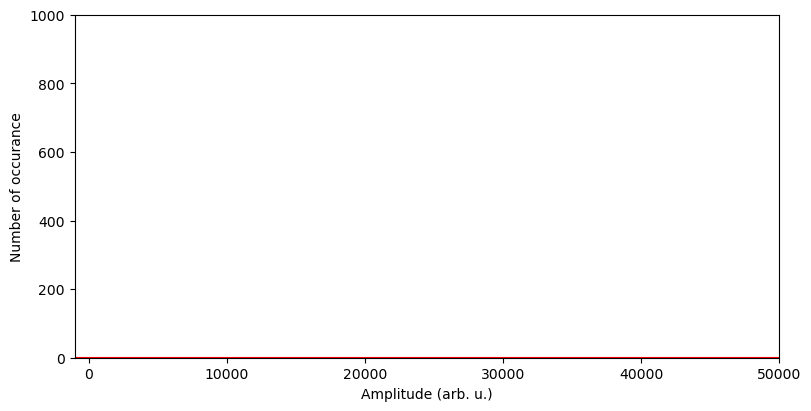

In [124]:
fig = plt.figure(constrained_layout=True, dpi=100, figsize=(8, 4))

gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[:, 0])

ax.bar(hist_edges[0:-1], Hnp, width=bin_sep, linewidth=1, ec='k', fc='#33aaff')
# ax.plot(hist_bins_fit, Hnp_hist2_fit, 'r-')
ax.plot(hist_bins_fit, Hnp_fit, 'r-')
ax.plot([threshold]*2, [0, 1.1*np.max(Hnp)], 'k--')
ax.set_xlim([-1e3, 5e4])
ax.set_ylim([0, 1000])
# ax.set_ylim([0, 1e4])
ax.set_ylabel('Number of occurance')
ax.set_xlabel('Amplitude (arb. u.)')

plt.show()

#### Asymmetric Gaussian

In [125]:
p_ini = [80, 28e3, 5e3, 7e3]

idx = np.argmin(np.abs(hist_edges - 2e4))
p_fit, p_err, goodness = fitting.fit_1d(hist_gauss_asymmetric, Hnp[idx:], hist_edges[idx:-1], p_ini)

x0 = p_fit[1]
sigma1 = p_fit[2]
sigma2 = p_fit[3]

idx_mod = np.argmin(np.abs(hist_edges - (p_fit[1] - sigma)))
p_fit, p_err, goodness = fitting.fit_1d(hist_gauss_asymmetric, Hnp[idx_mod:], hist_edges[idx_mod:-1], p_ini)

Hnp_fit = hist_gauss_asymmetric(hist_bins_fit, *p_fit)

x0 = p_fit[1]
sigma1 = p_fit[2]
sigma2 = p_fit[3]

threshold0 = x0 - 1 * sigma1
threshold1 = x0 - 1.5 * sigma1
threshold2 = x0 - 2 * sigma1

thresholds = [threshold0, threshold1, threshold2]

p_fit, p_err, goodness, thresholds, 1 - np.exp(-(1.5)**2)

c:\Users\hidek\OneDrive\Riken\Script\Python\DataAnalysis\qgm\fitting.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  fit_Rsquared = 1 - np.var(fit_residual) / np.var(y)


(array([-4.29873985e-17,  2.80000000e+04,  4.99999999e+03,  7.00000000e+03]),
 array([9.38716769e-18, 4.47503804e-06, 5.13272986e-06, 3.84085070e-06]),
 -inf,
 [23000.00000530567, 20500.00001026612, 18000.00001522657],
 0.8946007754381357)

## Load images and set system information

In [126]:
path_trans1 = path_org + '\\data%03d\\raw\\seq%05d_trans%03d.tiff' % (dataNo, seqNo, 1)
path_flat1 = path_org + '\\data%03d\\raw\\seq%05d_flat%03d.tiff' % (dataNo, seqNo, 1)

img1 = image.image(path_trans1)
img1.generate_bg_image(path_flat1, True)

In [127]:
(x0_px, y0_px) = (img1.image.shape[1]/2 - 6.27773814/0.18782061063985978,
                  img1.image.shape[0]/2 - 3.18408819/0.18782061063985978) # px
(x0_um, y0_um) = (x0_px*0.18782061063985978, y0_px*0.18782061063985978) # um

system_info = {'Magnification': 85.18766894374285,
               'Cloud center (px)': (x0_px, y0_px),
               'Cloud center (um)': (x0_um, y0_um),
              }

img1.system.set_info(**system_info)
img1.system.recalc_effective_pixel_size()

# img.system.info

Magnification
Cloud center (px)
Cloud center (um)


In [128]:
lattice1_info = {'Constant (px)': 3.770261,
                 'Constant (um)': 3.770261 * 0.18782061063985978,
                 'Angle (degree)': 19.849774260122633,
                 'Angle (radian)': 19.849774260122633 * np.pi / 180,
                }
lattice2_info = {'Constant (px)': 3.792326,
                 'Constant (um)': 3.792326 * 0.18782061063985978,
                 'Angle (degree)': 79.63134796355473,
                 'Angle (radian)': 79.63134796355473 * np.pi / 180,
                }
img1.system.lattice['Lattice 1'].set_info(**lattice1_info)
img1.system.lattice['Lattice 2'].set_info(**lattice2_info)

# img.system.lattice['Lattice 1'].info

Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)


In [129]:
psf_info = {'Model':'psf',
            'Effective NA': 0.592501443972206,
            'Offset count': 0,
            'Peak count': 2500,
           }
img1.system.psf.set_info(**psf_info)
img1.system.psf.recalc_resolution()

# img.system.psf.info

Model
Effective NA
Offset count
Peak count


In [130]:
xymesh = img1.generate_xymesh()

In [131]:
path_trans2 = path_org + '\\data%03d\\raw\\seq%05d_trans%03d.tiff' % (dataNo, seqNo, 2)
path_flat2 = path_org + '\\data%03d\\raw\\seq%05d_flat%03d.tiff' % (dataNo, seqNo, 2)

img2 = copy.deepcopy(img1)
img2.load_image(path_trans2, False)
img2.generate_bg_image(path_flat2, True)

## Applyh lowpass filter

In [132]:
img1_lowpass = copy.deepcopy(img1)
img1_lowpass.image, img_fft, (fx, fy), (FX, FY) = filter.lowpass(img1_lowpass, factor=1)

img2_lowpass = copy.deepcopy(img2)
img2_lowpass.image, img_fft, (fx, fy), (FX, FY) = filter.lowpass(img2_lowpass, factor=1)

## Search isolated atoms in each image

In [133]:
_ = search_atoms.search_atoms(img1, filter_factor=0.2)

In [134]:
_ = search_atoms.search_atoms(img2, filter_factor=0.2)

In [135]:
_ = search_atoms.search_atoms(img1_lowpass, filter_factor=0.2)

In [136]:
_ = search_atoms.search_atoms(img2_lowpass, filter_factor=0.2)

C:\Users\hidek\Anaconda3\envs\qgm6\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
C:\Users\hidek\Anaconda3\envs\qgm6\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


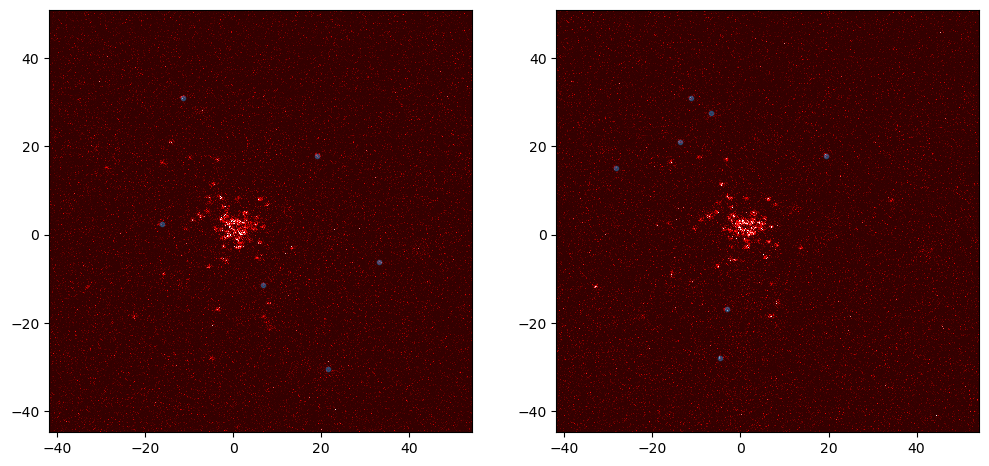

In [137]:
plt.figure(figsize=(12,8), dpi=100)

plt.subplot(1, 2, 1)
plt.pcolormesh(img1.xymesh[0], img1.xymesh[1], img1.image, cmap=cmap, vmin=0, vmax=2500)
plt.plot(img1.system.lattice['Origins']['X Center (um)'], img1.system.lattice['Origins']['Y Center (um)'], '.', alpha=0.5)
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.pcolormesh(img2.xymesh[0], img2.xymesh[1], img2.image, cmap=cmap, vmin=0, vmax=2500)
plt.plot(img2.system.lattice['Origins']['X Center (um)'], img2.system.lattice['Origins']['Y Center (um)'], '.', alpha=0.5)
plt.gca().set_aspect('equal')

plt.show()

## Set region of interest (ROI)

In [138]:
(x0_sub, x1_sub, y0_sub, y1_sub) = (-5, 5, -5, 5)

In [139]:
img1.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
img1_lowpass.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])

img2.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
img2_lowpass.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])

xymesh_ROI = img1.xymesh_ROI

In [140]:
(xs1, ys1) = img1.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')
(xs1_lowpass, ys1_lowpass) = img1_lowpass.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')

(xs2, ys2) = img2.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')
(xs2_lowpass, ys2_lowpass) = img2_lowpass.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')

## Show image of ROI

C:\Users\hidek\Anaconda3\envs\qgm6\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


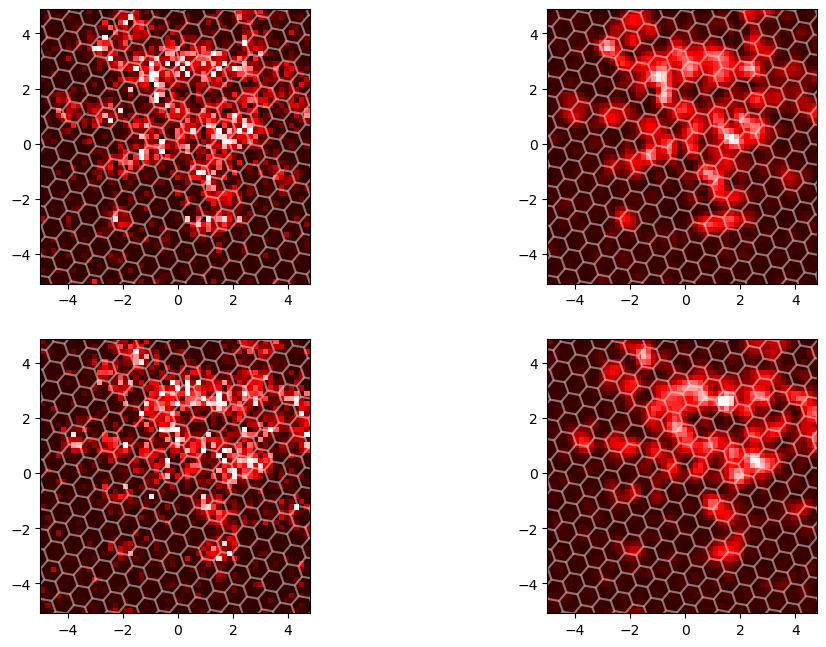

In [141]:
sep_lattice1 = img1.generate_lattice_separation(alpha=0.25, dx=-0.3, dy=-0.21)
sep_lattice2 = img1.generate_lattice_separation(alpha=0.25, dx=-0.2)
sep_lattice1_lowpass = img1_lowpass.generate_lattice_separation(alpha=0.25, dx=-0.25, dy=-0.21)
sep_lattice2_lowpass = img2_lowpass.generate_lattice_separation(alpha=0.25, dx=-0.2)

plt.figure(figsize=(12, 8), dpi=100)

for n, (img, sep_lattice) in enumerate(zip([img1, img1_lowpass, img2, img2_lowpass], [sep_lattice1, sep_lattice1_lowpass, sep_lattice2, sep_lattice2_lowpass])):
    g = plt.subplot(2, 2, n+1)
    plt.pcolormesh(img.xymesh_ROI[0], img.xymesh_ROI[1], img.image_ROI, cmap=cmap, vmin=0, vmax=2500)
#     plt.plot(img.system.lattice['Lattice sites']['X Center'], img1.system.lattice['Lattice sites']['Y Center'], '.', alpha=0.5)
    g.add_collection(sep_lattice)
    plt.xlim([np.min(img.xymesh_ROI[0]), np.max(img.xymesh_ROI[0])])
    plt.ylim([np.min(img.xymesh_ROI[1]), np.max(img.xymesh_ROI[1])])
    plt.gca().set_aspect('equal')

plt.show()

## Reconstruct images

In [142]:
if False:
    img1_test = copy.deepcopy(img1)
    img2_test = copy.deepcopy(img2)
else:
    img1_test = copy.deepcopy(img1_lowpass)
    img2_test = copy.deepcopy(img2_lowpass)

## Set region of interest (ROI)

In [143]:
# (x0_sub, x1_sub, y0_sub, y1_sub) = (-30, 30, -30, 30)
# (x0_sub, x1_sub, y0_sub, y1_sub) = (-20, 20, -20, 20)
(x0_sub, x1_sub, y0_sub, y1_sub) = (-16, 16, -16, 16)
# (x0_sub, x1_sub, y0_sub, y1_sub) = (-15, 15, -15, 15)
# (x0_sub, x1_sub, y0_sub, y1_sub) = (-10, 10, -10, 10)
(x0_sub, x1_sub, y0_sub, y1_sub) = (-3, 3, -0, 6)

img1_test.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
img2_test.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
xymesh_ROI = img1_test.xymesh_ROI
(xs1_test, ys1_test) = img1_test.generate_lattice_sites(Nsite=401, rxlim=16, rylim=16, unit='um', limits='square')
(xs2_test, ys2_test) = img2_test.generate_lattice_sites(Nsite=401, rxlim=16, rylim=16, unit='um', limits='square')

### Modify lattice site positions

In [144]:
img1_test.system.lattice['Lattice sites']['X Center'] += 0
img1_test.system.lattice['Lattice sites']['Y Center'] += 0

xs1_test = img1_test.system.lattice['Lattice sites']['X Center']
ys1_test = img1_test.system.lattice['Lattice sites']['Y Center']

img2_test.system.lattice['Lattice sites']['X Center'] += 0
img2_test.system.lattice['Lattice sites']['Y Center'] += 0

xs2_test = img2_test.system.lattice['Lattice sites']['X Center']
ys2_test = img2_test.system.lattice['Lattice sites']['Y Center']

### Generate matrix of point spread functions

In [145]:
t1 = time()

if True:
    img1_test.generate_psfm(psf_model='gaussian')
    img2_test.generate_psfm(psf_model='gaussian')
    
else:
    img1_test.generate_psfm()
    img2_test.generate_psfm()
    
t2 = time()

print('Elapsed time: %f s' % (t2 -t1))

Elapsed time: 0.138278 s


### Deconvolution

In [146]:
img1_test_dec, factor_evol1 = deconvolution(img1_test, Niter=iter_deconv)
img2_test_dec, factor_evol2 = deconvolution(img2_test, Niter=iter_deconv)

### Evaluate site occupation

In [147]:
threshold = 7000.0

img1_test_eval = evaluation.site_occupation_evaluation(img1_test, threshold=threshold)
img2_test_eval = evaluation.site_occupation_evaluation(img2_test, threshold=threshold)

### Show results of decovolution

C:\Users\hidek\Anaconda3\envs\qgm6\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


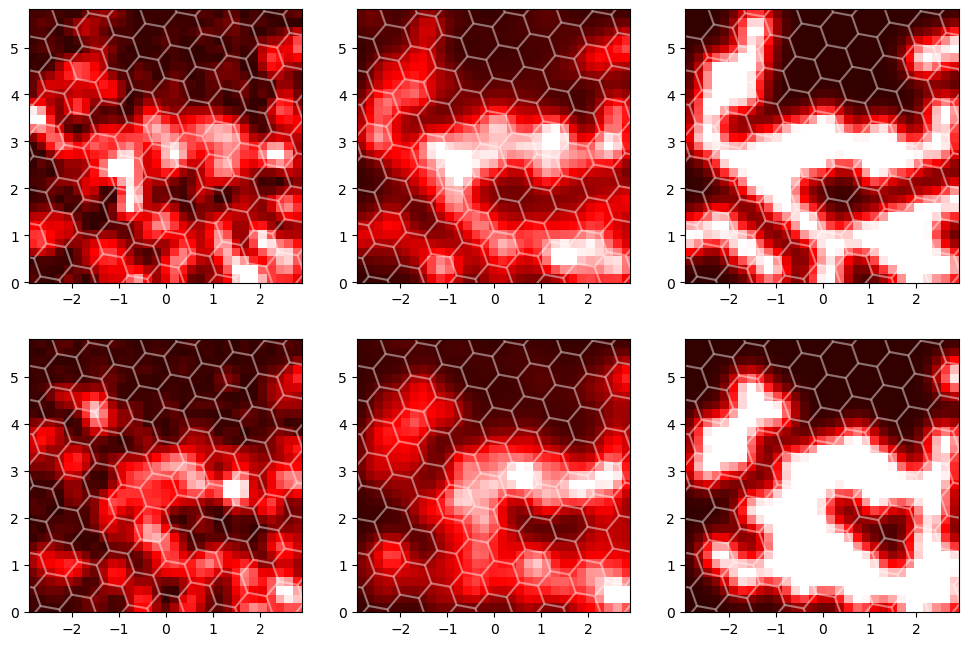

In [148]:
plt.figure(figsize=(12, 8), dpi=100)

imgs = [img1_test.image_ROI, img1_test_dec, img1_test_eval, img2_test.image_ROI, img2_test_dec, img2_test_eval]

for n, img in enumerate(imgs):
    if n < 3:
        sep_lattice = img1_test.generate_lattice_separation(alpha=0.25)
    else:
        sep_lattice = img2_test.generate_lattice_separation(alpha=0.25)
    
    g = plt.subplot(2, 3, n+1)
    plt.pcolormesh(xymesh_ROI[0], xymesh_ROI[1], img, cmap=cmap, vmin=0, vmax=np.max(img)*8/10)
#     plt.plot(xs1_test, ys1_test, '.', alpha=0.5)
    g.add_collection(sep_lattice)
    plt.xlim([np.min(xymesh_ROI[0]), np.max(xymesh_ROI[0])])
    plt.ylim([np.min(xymesh_ROI[1]), np.max(xymesh_ROI[1])])
    plt.gca().set_aspect('equal')

plt.show()